## Connect to git ##

In [ ]:
#!git clone https://github.com/Sharonnae/FitnessAI.git

## Checkout to the relevant branch ##

In [ ]:
#%cd /content/FitnessAI
#!git checkout CNN---Accuracy

# Imports #

In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import random_split

In [6]:
! rm -rf '/content/FitnessAI/CNN - Accuracy/deadlift/.ipynb_checkpoints'

# Load Dataset

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize((128,128))
     ])

dataset = torchvision.datasets.ImageFolder(r'/Users/rotemcohen/FitnessAI/CNN - Accuracy/deadlift', transform=transform)

# Split the data into Train set and Test set

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataset_train, dataset_test = random_split(dataset, (0.8, 0.2))
len(dataset_train), len(dataset_test)

batch_size = 2

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Print a single image and label

/Users/rotemcohen/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


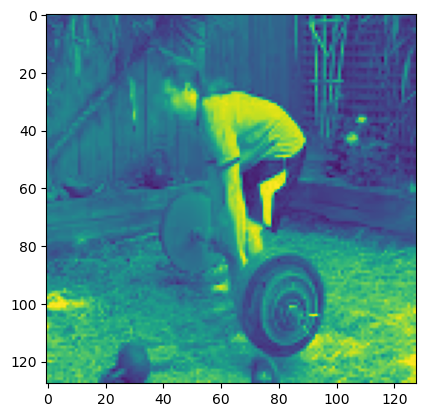

In [8]:
import matplotlib.pyplot as plt
for i in dataset:
  plt.imshow(i[0][0].numpy())
  break


# Print a batch of images and labels from the train set

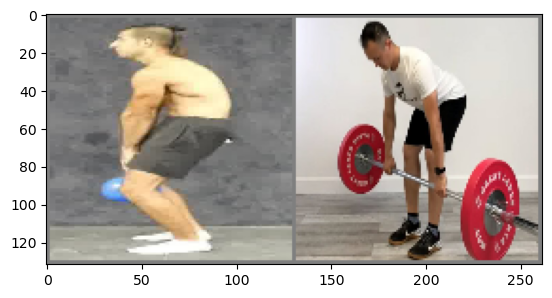

correct incorrect


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# labels
classes = {
    0: 'correct',
    1: 'incorrect',
}

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))


# Use a GPU if it is available, and the CPU otherwise

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# CNN model

In [44]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(13456, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()

  
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

net = Net().to(device)



# Train

In [45]:

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 5

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

ValueError: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.

# Test

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy {100 - (100 * correct // total)} %')

Accuracy 49 %
